In [3]:
import pandas as pd
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

In [4]:
def DF_handling(df):
    df = df.rename(columns={'Unnamed: 0':'id'})

    # Age category (proxy for attractiveness)
    df['attractiveness'] = df.apply(lambda x: True if (x.subject_age<46) else False, axis=1)
    
    return df

def match_pairs(df, reason_searches):
    matching=pd.DataFrame({'men':[],'women':[]})
    AOD = 0
    # Match 1 woman and 1 man with same attributes
    for reason in reason_searches:
        for race in ('white','black','hispanic'):
            for attractiveness in ('True', 'False'):
                for contraband in ('True', 'False'):
                    query = "reason_for_search=='"+reason+"' & subject_race=='"+race+"' & attractiveness=="+attractiveness+" & contraband_found=="+contraband
                    data = df.query(query).copy()
                    id_M = np.array(data[data['subject_sex']=='male'].id)
                    id_W = np.array(data[data['subject_sex']=='female'].id)
                    if ((len(id_M)>0) & (len(id_W)>0)):
                        if (len(id_M)>len(id_W)):
                            for i in np.arange(0,len(id_W)):
                                matching = matching.append({'men':id_M[i],'women':id_W[i]},ignore_index=True)
                          
                        if (len(id_M)<len(id_W)):
                            for i in np.arange(0,len(id_M)):
                                matching = matching.append({'men':id_M[i],'women':id_W[i]},ignore_index=True)
    return matching

def match_pairs2(df, reason_stops):
    matching=pd.DataFrame({'men':[],'women':[]})
    AOD = 0
    # Match 1 woman and 1 man with same attributes
    for reason in reason_stops:
        for race in ('white','black','hispanic'):
            for attractiveness in ('True', 'False'):
                for contraband in ('True', 'False'):
                    query = "reason_for_stop=='"+str(reason)+"' & subject_race=='"+race+"' & attractiveness=="+attractiveness+" & contraband_found=="+contraband
                    data = df.query(query).copy()
                    id_M = np.array(data[data['subject_sex']=='male'].id)
                    id_W = np.array(data[data['subject_sex']=='female'].id)
                    if ((len(id_M)>0) & (len(id_W)>0)):
                        if (len(id_M)>len(id_W)):
                            for i in np.arange(0,len(id_W)):
                                matching = matching.append({'men':id_M[i],'women':id_W[i]},ignore_index=True)

                        if (len(id_M)<len(id_W)):
                            for i in np.arange(0,len(id_M)):
                                matching = matching.append({'men':id_M[i],'women':id_W[i]},ignore_index=True)

    return matching

def AOD_s(df, matching):
    # Averaged outcome difference (AOD) in search decision s 
    N_matches = len(matching)
    diff = np.zeros(N_matches)

    for i in np.arange(0,N_matches):
        s_man = int(np.array(df[df['id']==matching.loc[i,'men']].search_person))
        s_woman = int(np.array(df[df['id']==matching.loc[i,'women']].search_person))
        diff[i] = s_man-s_woman                    
    AOD = diff.sum()/N_matches    
    
    return AOD, diff

def bootstrap_CI(data, nbr_draws):
    # Confidence interval
    # Bootstrap CI function from exercise session 2
    means = np.zeros(nbr_draws)
    data = np.array(data)

    for n in range(nbr_draws):
        indices = np.random.randint(0, len(data), len(data))
        data_tmp = data[indices] 
        means[n] = np.nanmean(data_tmp)

    return [np.nanpercentile(means, 5),np.nanpercentile(means, 95)]

def analyse2(df,n):
    df = DF_handling(df)
    df['outcome'] = df.apply(lambda x: 1 if (x.arrest_made or x.citation_issued) else 0, axis=1)
    #print(df.head(2))
    
    reason_stops = list(Counter(df['reason_for_stop']).keys())
    Counter(df['reason_for_stop'])
    
    #print(reason_stops)
    
    matching = match_pairs2(df, reason_stops)
    
    N_matches = len(matching)
    diff = np.zeros(N_matches)
    for i in np.arange(0,N_matches):
        outcome_man = np.array(df[df['id']==matching.loc[i,'men']].outcome)
        outcome_woman = np.array(df[df['id']==matching.loc[i,'women']].outcome)
        diff[i] = outcome_man-outcome_woman                    
    AOD = diff.sum()/N_matches
    
    CI = bootstrap_CI(diff, 1000)
    
    return AOD, CI[0], CI[1]
    
def state(df, n):
    df = DF_handling(df)

    # Feature analysis : reason for search
    Counter(df['reason_for_search'])

    # Plot of the possible combination of the reason for search
    #plt.figure(figsize=[18,8])
    #plt.bar(Counter(df.dropna(subset=['reason_for_search']).reason_for_search).keys(), Counter(df.dropna(subset=['reason_for_search']).reason_for_search).values())

    #print('There are %d combinations of reasons for the policeman to decide to operate a search, among which, the most represented combinations are (in descending order of importance) :' %len(Counter(df['reason_for_search']).items()))
    #print(list(sorted(Counter(df_sandiego.dropna(subset=['reason_for_search']).reason_for_search).items(), key=lambda x:x[1],  reverse=True))[:13])

    # Possible reasons for search : n combinations chosen
    reason_searches = sorted(Counter(df['reason_for_search']), key=Counter(df['reason_for_search']).get, reverse = True)[:n]
    
    matching = match_pairs(df, reason_searches)

    [AOD, diff] = AOD_s(df, matching)

    CI = bootstrap_CI(diff, 1000)

    #print('Averaged outcome difference %.4f with [%.4f, %.4f] 95%% confidence intervals' %(AOD, CI[0], CI[1]))
    return AOD, CI[0], CI[1]

def s_vehi_or_not(df, n):

    df = DF_handling(df)

    reason_searches = sorted(Counter(df['reason_for_search']), key=Counter(df['reason_for_search']).get, reverse = True)[:n]

    matching = match_pairs(df, reason_searches)

    df.index = df['id']
    matching['men']= matching['men'].apply(lambda x: int(x))
    matching['women']= matching['women'].apply(lambda x: int(x))
    matching.index = matching['women']

    search_vehicle_w = dict(tuple(df.loc[matching['women']].groupby('search_vehicle')))
    search_vehicle_m = dict(tuple(df.loc[matching['men']].groupby('search_vehicle')))

    [AOD_vehicule_searched, diff_veh] = AOD_s(df, matching.loc[search_vehicle_w[True].id].reset_index(drop=True))

    [AOD_vehicule_not_searched, diff_no_veh] = AOD_s(df, matching.loc[search_vehicle_w[False].id].reset_index(drop=True))
    
    return matching, AOD_vehicule_searched, diff_veh, AOD_vehicule_not_searched, diff_no_veh, search_vehicle_w, search_vehicle_m

def reason_type_search(df, matching, df_w):
    df = DF_handling(df)
    AOD_searched_ = dict()
    diff_ = dict()
    search_reason_w = dict(tuple(df_w.groupby('reason_for_search')))
    for idx, reason in enumerate(search_reason_w.keys()):
        AOD_searched_[idx], diff_[idx] = AOD_s(df, matching.loc[search_reason_w[reason].id].reset_index(drop=True))
    return AOD_searched_, diff_

In [5]:
df_austin = pd.read_csv('data/df_austin.csv')
df_charlotte = pd.read_csv("data/df_charlotte.csv")
df_greensboro = pd.read_csv("data/df_greensboro.csv")
df_MD = pd.read_csv('data/df_MD.csv')
df_nashville = pd.read_csv("data/df_nashville.csv")
df_neworleans = pd.read_csv("data/df_neworleans.csv")
df_raleigh = pd.read_csv("data/df_raleigh.csv")
df_sandiego = pd.read_csv("data/df_sandiego.csv")
df_sanfrancisco = pd.read_csv("data/df_sanfrancisco.csv")
df_WA = pd.read_csv("data/df_WA.csv")



dicto = {'austin': df_austin,'charlotte': df_charlotte, 'greensboro': df_greensboro,'MD': df_MD,'nashville': df_nashville, 'neworleans': df_neworleans,
         'raleigh': df_raleigh, 'sandiego': df_sandiego,'sanfrancisco': df_sanfrancisco,'WA': df_WA}

df = pd.DataFrame(columns = ["name",'total_m', 'total_f', 'stop_rate_m',"stop_rate_f","search_rate_arrest_m","search_rate_arrest_f",
                             "search_rate_contraband_m","search_rate_contraband_f","frisk_rate_m","frisk_rate_f",
                             "AOD", "CI0", "CI1","AOD_2", "CI0_2", "CI1_2",
                            "AOD_vehicule_searched", "AOD_vehicule_not_searched", "search_vehicle_w", "search_vehicle_m"]) 

/usr/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning:

Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.



In [6]:
#we have lost some columns
for name in ["austin","charlotte","greensboro","MD","nashville","neworleans","raleigh","sandiego","sanfrancisco","WA"]:
    data = dicto[name]
    print(data.shape[1])
    

10
14
14
12
12
12
14
12
10
10


In [7]:
df_MD.dtypes
df_charlotte.dtypes

Unnamed: 0             int64
subject_age          float64
subject_race          object
subject_sex           object
arrest_made             bool
citation_issued         bool
warning_issued          bool
contraband_found        bool
frisk_performed         bool
search_person           bool
search_vehicle          bool
reason_for_frisk      object
reason_for_search     object
reason_for_stop       object
dtype: object

In [41]:
list_name = ["austin","charlotte","greensboro","MD","nashville","neworleans","raleigh","sandiego","sanfrancisco","WA"]
list_name = ["austin","charlotte","greensboro","MD","nashville","neworleans","raleigh","sandiego"]
list_name_print = ["Austin, TX","Charlotte, NC","Greensboro, NC","Maryland","Nashville, TN","New Orleans, LA","Raleigh, NC","San diego, CA"]
#list_name = ["charlotte"]

population_dico = {'austin': [978908,0.492],'charlotte': [885708,0.481], 'greensboro': [296710,0.535],'MD': [6045680,0.516],'nashville': [694144,0.518], 'neworleans': [390144,0.525],
         'raleigh': [474069,0.518], 'sandiego': [1423851,0.495],'sanfrancisco': [881549,0.490],'WA': [7614893,0.499]}

for name in list_name:

    data = dicto[name]
    print(name)
    data['attractiveness'] = data.apply(lambda x: True if (x.subject_age<46) else False, axis=1)
    
    #distribution dataset
    total_m = data[data["subject_sex"] == "male"]
    total_f = data[data["subject_sex"] == "female"]
    #print(total_m.shape[0])
    #print(total_f.shape[0])

    # stop rate 
    # https://www.census.gov/quickfacts/charlottecitynorthcarolina
    population_charlotte = population_dico[name][0]
    population_charlotte_m = int(population_charlotte*population_dico[name][1])
    population_charlotte_f = population_charlotte - population_charlotte_m

    stop_rate_m = total_m.shape[0] / population_charlotte_m 
    stop_rate_f = total_f.shape[0] / population_charlotte_f
    #print(stop_rate_f)
    #print(stop_rate_m)

    # Search rates
    search_rate_arrest_m = []
    search_rate_arrest_f = []
    search_rate_contraband_m = []
    search_rate_contraband_f = []

    for name_search in ["search_person","search_vehicle"]:
        if name_search != "search_person" or name != "WA":
            total_search_m = total_m[total_m[name_search] == True]
            total_search_f = total_f[total_f[name_search] == True]

            if name != "austin":

                search_arrest_m = total_search_m[total_search_m["arrest_made"] == True]
                search_arrest_f = total_search_f[total_search_f["arrest_made"] == True]

                search_rate_arrest_m.append(search_arrest_m.shape[0]/total_search_m.shape[0])
                search_rate_arrest_f.append(search_arrest_f.shape[0]/total_search_f.shape[0])

            #print(" -- "+name_search+" arrest made")
            #print(search_rate_arrest_f)
            #print(search_rate_arrest_m)

            search_contraband_m = total_search_m[total_search_m["contraband_found"] == True]
            search_contraband_f = total_search_f[total_search_f["contraband_found"] == True]

            search_rate_contraband_m.append(search_contraband_m.shape[0]/total_search_m.shape[0])
            search_rate_contraband_f.append(search_contraband_f.shape[0]/total_search_f.shape[0])

            #print(" -- "+name_search+" contraband found")
            #print(search_rate_contraband_f)
            #print(search_rate_contraband_m)

    # frisk rate
    # Search rates
    """
    total_frisk_m = total_m[total_m["frisk_performed"] == True]
    total_frisk_f = total_f[total_f["frisk_performed"] == True]

    frisk_m = total_frisk_m[total_frisk_m["arrest_made"] == True]
    frisk_f = total_frisk_f[total_frisk_f["arrest_made"] == True]

    frisk_rate_m = frisk_m.shape[0]/total_frisk_m.shape[0]
    frisk_rate_f = frisk_f.shape[0]/total_frisk_f.shape[0]

    #print(frisk_rate_f)
    #print(frisk_rate_m)
    """
    
    
    AOD, CI0, CI1 = 0,0,0 
    AOD_vehicule_searched, AOD_vehicule_not_searched, AOD_searched_ = 0,0,0
    if name not in ["nashville","neworleans"]:
        AOD, CI0, CI1 = state(data, n=2)
        matching, AOD_vehicule_searched, diff_veh, AOD_vehicule_not_searched, diff_no_veh, search_vehicle_w, search_vehicle_m = s_vehi_or_not(data, n=4)
        AOD_searched_, diff_ = reason_type_search(data, matching, search_vehicle_w[True])
        
    AOD_2, CI0_2, CI1_2 = 0,0,0 
    if name not in ["austin"]:
        AOD_2, CI0_2, CI1_2 = analyse2(data,2)
    
    ['total_m', 'total_f', 'stop_rate_m',"stop_rate_f","search_rate_arrest_m","search_rate_arrest_f",
                                 "search_rate_contraband_m","search_rate_contraband_f","frisk_rate_m","frisk_rate_f"]
    
    df = df.append({"name" : name,'total_m' : total_m.shape[0], 'total_f' : total_f.shape[0], 'stop_rate_m' : stop_rate_m,"stop_rate_f" : stop_rate_f,"search_rate_arrest_m" : search_rate_arrest_m ,
                    "search_rate_arrest_f" : search_rate_arrest_f,"search_rate_contraband_m" : search_rate_contraband_m,"search_rate_contraband_f" : search_rate_contraband_f,
                   "AOD" : AOD, "CI0" : CI0, "CI1" : CI1,"AOD_2" : AOD_2, "CI0_2" : CI0_2, "CI1_2" : CI1_2,
                   "AOD_vehicule_searched" : AOD_vehicule_searched,"AOD_vehicule_not_searched":AOD_vehicule_not_searched,
                    "AOD_searched_":AOD_searched_},ignore_index = True)
                    #"frisk_rate_m" : frisk_rate_m,"frisk_rate_f" : frisk_rate_f},  
                    #ignore_index = True) 



austin


KeyboardInterrupt: 

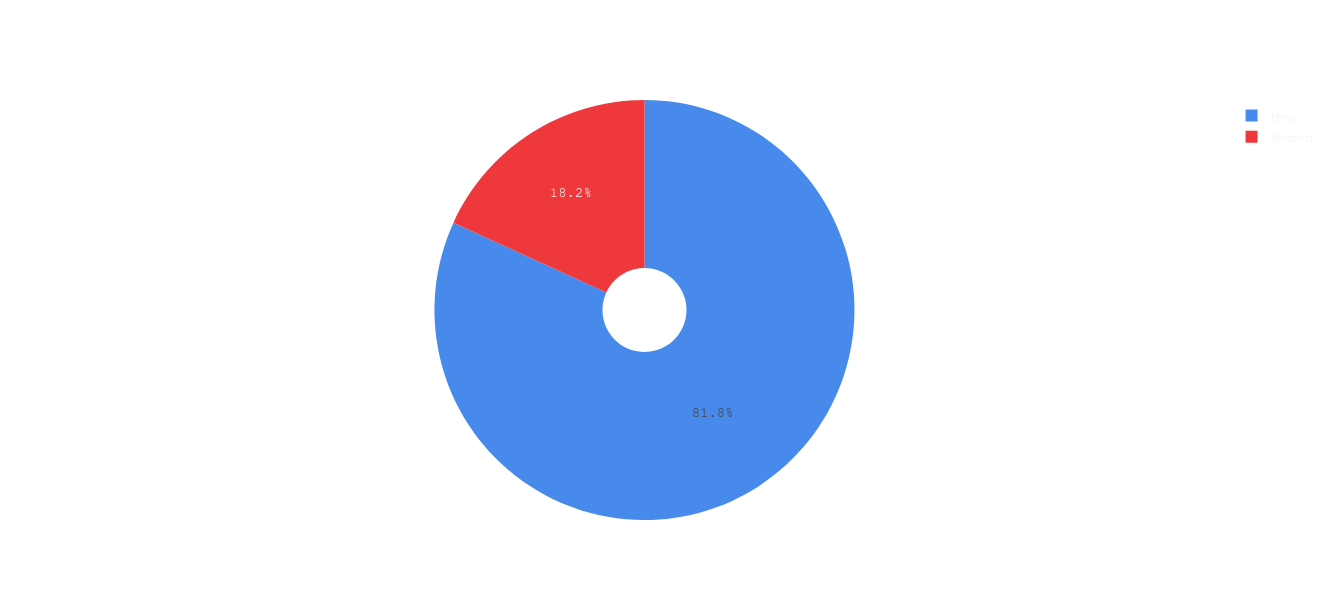

In [74]:
#hit rate
#first plot ,show % men women in our data
labels = ['Women','Men']
values = [df["total_f"].sum(), df["total_m"].sum()]
fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.2)])
fig.update_layout(
        autosize=False,
        paper_bgcolor='rgba(0,0,0,0)',
        font = dict(size=14, family='Courier', color="#F5F5F5"),
        width=600,
        height=600,
        dragmode = False,
    )
fig.update_traces( marker=dict(colors=['#EF383B', '#478AEC']))
fig.show()
pio.write_html(fig, file='MenWomenTotal.html', auto_open=True)

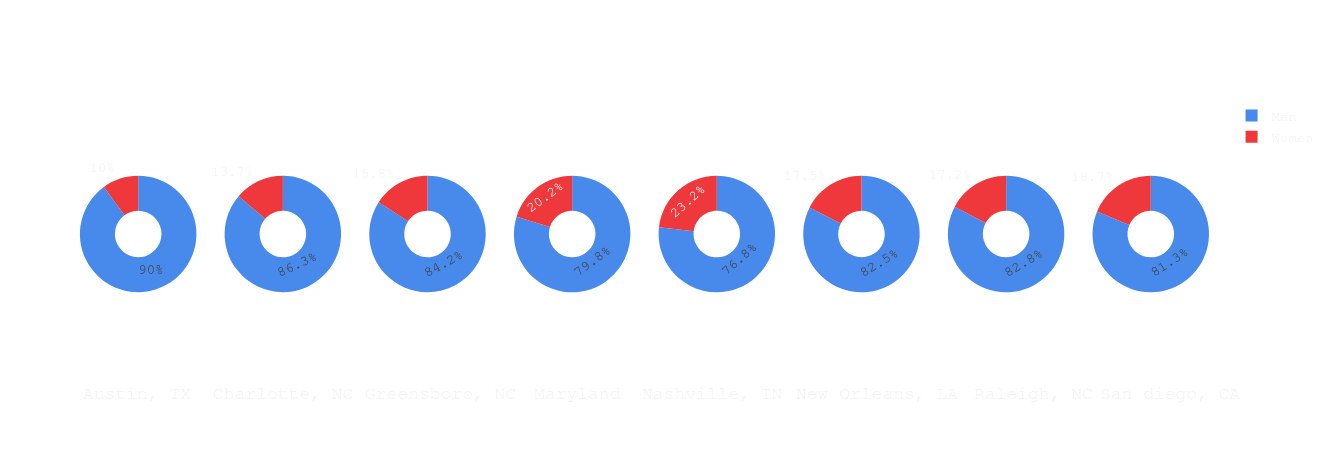

In [62]:
list_spec = []
for i in range(len(list_name)):
    list_spec.append({'type':'domain'})

fig = make_subplots(rows=1, cols=len(list_name), specs=[list_spec])
for i in range(len(list_name)):
    fig.add_trace(go.Pie(labels=labels, values=[df["total_f"][i],df["total_m"][i]], name=list_name_print[i]),1, 1+i)

# Use `hole` to create a donut-like pie chart
fig.update_traces(hole=.4, hoverinfo="label+percent+name")

annotation_circle = []
distance = [-0.00,0.115,0.25,0.44,0.56,0.78,0.90,1.03]
for i in range(len(list_name)):
    annotation_circle.append(dict(text=list_name_print[i], x=distance[i], y=-0.155, font_size=18, showarrow=False))
    
fig.update_layout(
    # Add annotations in the center of the donut pies.
    font = dict(size=14, family='Courier', color="#F5F5F5"),
    paper_bgcolor='rgba(0,0,0,0)',
    annotations=annotation_circle)
fig.update_traces( marker=dict(colors=['#EF383B', '#478AEC']))
fig.show()
pio.write_html(fig, file='MenWomenList.html', auto_open=True)

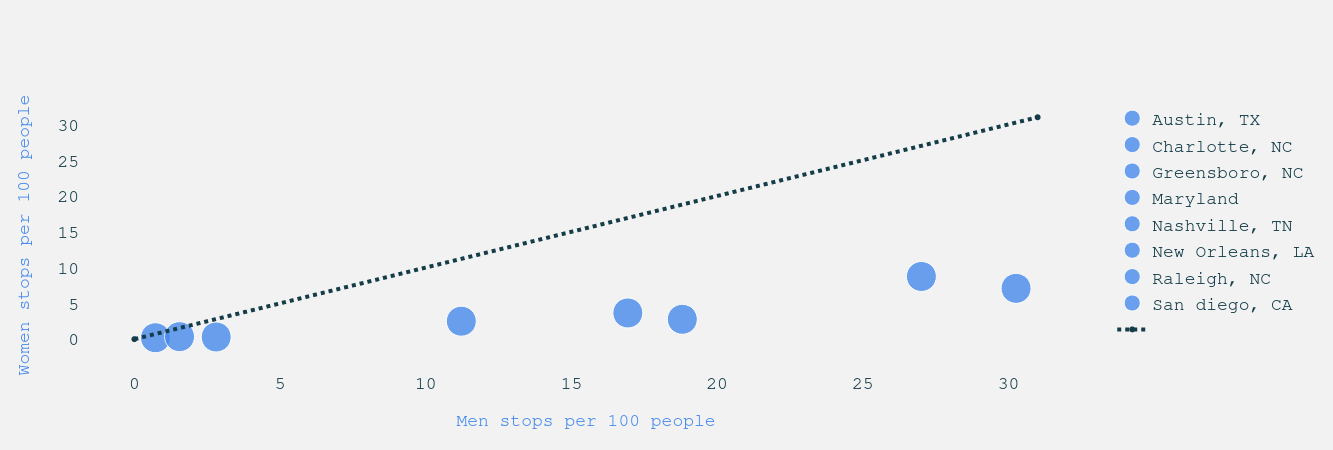

In [65]:
#stop rate
fig = go.Figure()


marker_var =dict(
        color=['#478AEC'],
        opacity=[0.8],
    )

for i in range(len(list_name)):
    fig.add_trace(go.Scatter(x=[df["stop_rate_m"][i]*100], y=[df["stop_rate_f"][i]*100],mode='markers', marker=marker_var ,name=list_name_print[i], marker_size=[30]))

    
color = "#478AEC"

fig.add_trace(go.Scatter(x=[0,31], y=[0,31], name='',line=dict(color='#143D49', width=4,dash='dot')))
fig.update_layout(
        font = dict(size=18, family='Courier', color="#143D49"),
        paper_bgcolor='#F2F2F2',
        plot_bgcolor='rgba(0,0,0,0)',
        autosize=True,
        dragmode = False,
    )


fig.update_xaxes(gridcolor = 'rgba(25, 229, 229,0)',title_font = dict(size=18, family='Courier', color=color),zeroline=False)
fig.update_yaxes(gridcolor = 'rgba(255, 229, 229,0)',title_font = dict(size=18, family='Courier', color=color),zeroline=False)
fig.update_xaxes(title_text='Men stops per 100 people')
fig.update_yaxes(title_text='Women stops per 100 people')
fig.show()
pio.write_html(fig, file='stopRate.html', auto_open=True)

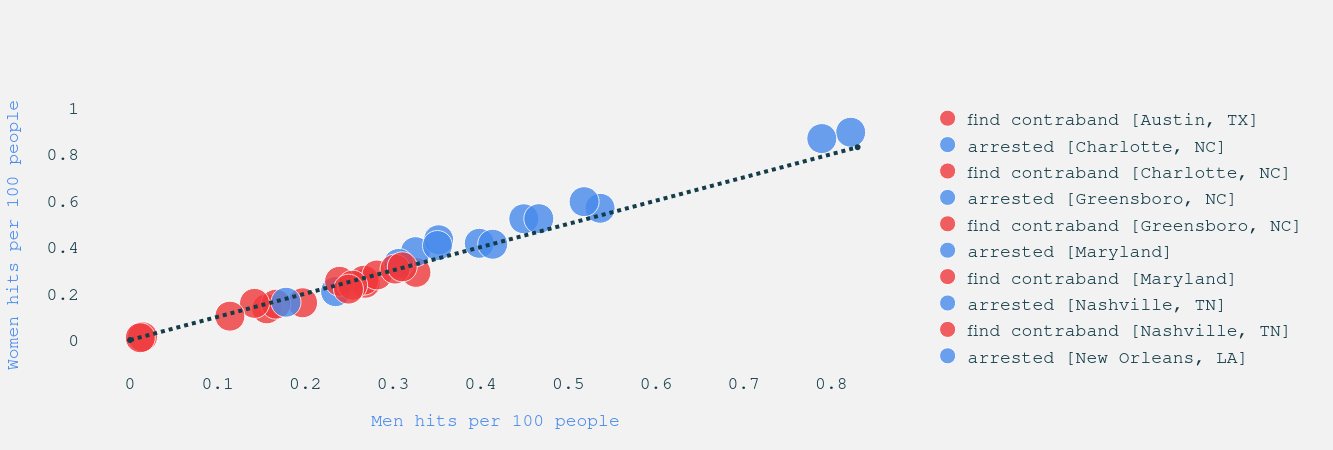

In [76]:
#hit rate
fig = go.Figure()


marker_var =dict(
        color=['#478AEC',"#478AEC"],
        opacity=[0.8,0.8],
    )
marker_var2 =dict(
        color=['#EF383B','#EF383B'],
        opacity=[0.8,0.8],
    )
marker_var3 =dict(
        color=['#002E79'],
        opacity=[0.8],
    )
marker_var4 =dict(
        color=['#E76A40'],
        opacity=[0.8],
    )
#"search_rate_arrest_m","search_rate_arrest_f", "search_rate_contreband_m","search_rate_contreband_f"
for i in range(len(list_name)):
    fig.add_trace(go.Scatter(x=df["search_rate_arrest_m"][i], y=df["search_rate_arrest_f"][i],mode='markers', marker=marker_var ,name="arrested ["+list_name_print[i]+"]", marker_size=[30,30],text=['<br>search_person', '<br>search_vehicle']))
    fig.add_trace(go.Scatter(x=df["search_rate_contraband_m"][i], y=df["search_rate_contraband_f"][i],mode='markers', marker=marker_var2 ,name="find contraband ["+list_name_print[i]+"]", marker_size=[30,30],text=['<br>search_person', '<br>search_vehicle']))
    
color = "#478AEC"

fig.add_trace(go.Scatter(x=[0,0.83], y=[0,0.83], name='',line=dict(color='#143D49', width=4,dash='dot')))
fig.update_layout(
        font = dict(size=18, family='Courier', color="#143D49"),
        paper_bgcolor='#F2F2F2',
        plot_bgcolor='rgba(0,0,0,0)',
        autosize=True,

        dragmode = False,
    )


fig.update_xaxes(gridcolor = 'rgba(25, 229, 229,0)',title_font = dict(size=18, family='Courier', color=color),zeroline=False)
fig.update_yaxes(gridcolor = 'rgba(255, 229, 229,0)',title_font = dict(size=18, family='Courier', color=color),zeroline=False)
fig.update_xaxes(title_text='Men hits per 100 people')
fig.update_yaxes(title_text='Women hits per 100 people')
fig.show()
pio.write_html(fig, file='hitRate.html', auto_open=True)

['TX', 'NC', 'NC', 'MD', 'NC', 'CA']


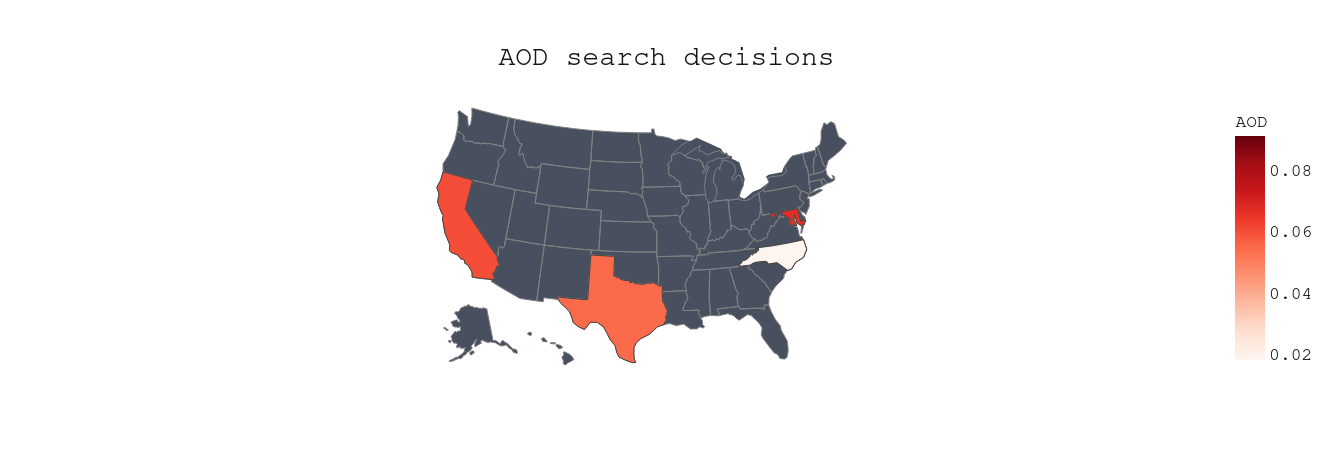

In [13]:
#df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2011_us_ag_exports.csv')

code_state = {'austin': "TX",'charlotte': "NC", 'greensboro': "NC",'MD': "MD",'nashville': "TN", 'neworleans': "LA",
         'raleigh': "NC", 'sandiego': "CA",'sanfrancisco': "CA",'WA': "WA"}

list_state = [code_state[v] for v in list_name]
list_state.remove('LA')
list_state.remove('TN')
print(list_state)

df_copy = df.copy()
df_copy = df_copy.drop([4, 5])

fig = go.Figure(data=go.Choropleth(
    locations=list_state, # Spatial coordinates
    z = df_copy['AOD'].astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Reds',
    colorbar_title = "AOD",
))

fig.update_layout(
    geo_scope='usa', # limite map scope to USA
    font = dict(size=18, family='Courier', color="#14161A"),
    paper_bgcolor ='rgba(0,0,0,0)',
    plot_bgcolor ='rgba(0,0,0,0)',
    autosize=True,
    title={
        'text': "AOD search decisions",
        'y':0.9,
        'x':0.5,
        "font":dict(size=28, color="#14161A"),
        'xanchor': 'center',
        'yanchor': 'top'},
    dragmode = False,
    geo=dict(bgcolor= 'rgba(0,0,0,0)',lakecolor='rgba(0,0,0,0)',landcolor='#485060',subunitcolor='grey')
)

fig.show()
#print(df['code'])
pio.write_html(fig, file='map1.html', auto_open=True)

['NC', 'NC', 'MD', 'TN', 'LA', 'NC', 'CA']


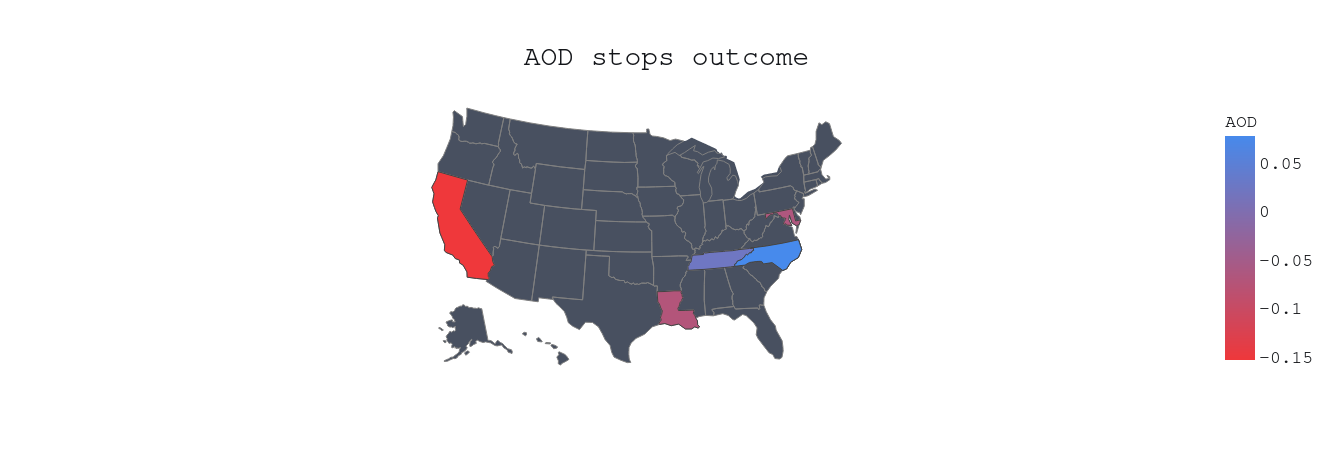

In [14]:
code_state = {'austin': "TX",'charlotte': "NC", 'greensboro': "NC",'MD': "MD",'nashville': "TN", 'neworleans': "LA",
         'raleigh': "NC", 'sandiego': "CA",'sanfrancisco': "CA",'WA': "WA"}

list_state = [code_state[v] for v in list_name]
list_state.remove('TX')
print(list_state)

df_copy = df.copy()
df_copy = df_copy.drop([0])

fig = go.Figure(data=go.Choropleth(
    locations=list_state, # Spatial coordinates
    z = df_copy['AOD_2'].astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = [[0, "#EF383B"],[1, "#478AEC"]],
    colorbar_title = "AOD",
))

fig.update_layout(
    geo_scope='usa', # limite map scope to USA
    font = dict(size=18, family='Courier', color="#14161A"),
    paper_bgcolor ='rgba(0,0,0,0)',
    plot_bgcolor ='rgba(0,0,0,0)',
    autosize=True,
    dragmode = False,
    title={
        'text': "AOD stops outcome",
        'y':0.9,
        'x':0.5,
        "font":dict(size=28, color="#14161A"),
        'xanchor': 'center',
        'yanchor': 'top'},
    geo=dict(bgcolor= 'rgba(0,0,0,0)',lakecolor='rgba(0,0,0,0)',landcolor='#485060',subunitcolor='grey')
)

fig.show()
pio.write_html(fig, file='map2.html', auto_open=True)

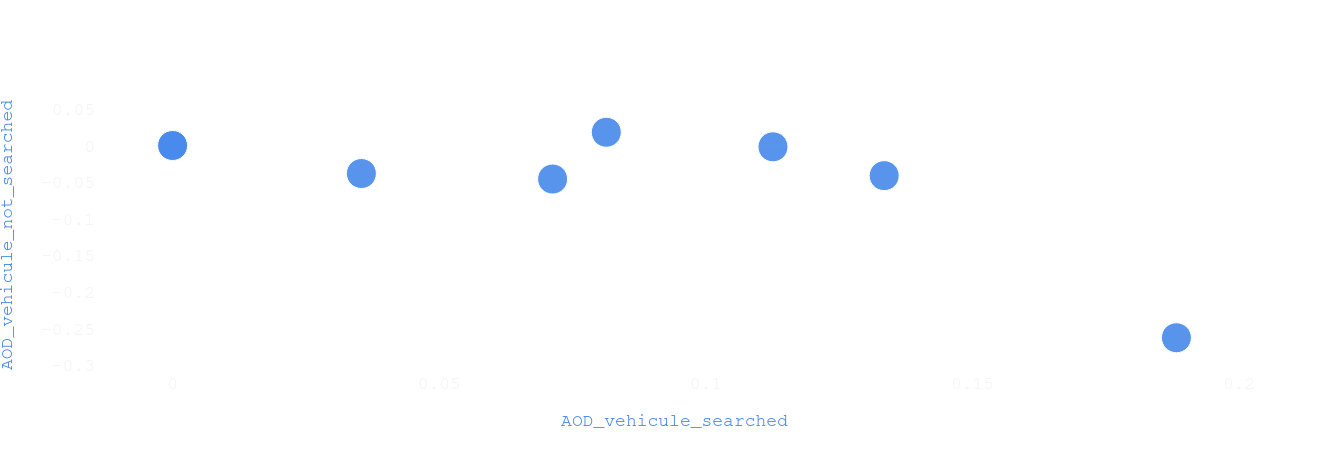

In [64]:
# AOD
# AOD_vehicule_searched 	AOD_vehicule_not_searched 	search_vehicle_w 	search_vehicle_m 	AOD_searched_
fig = go.Figure()


marker_var =dict(
        color=['#478AEC',"#478AEC","#478AEC","#478AEC","#478AEC","#478AEC","#478AEC","#478AEC"],
        opacity=[0.9],
    )
marker_var2 =dict(
        color=['#EF383B','#EF383B'],
        opacity=[0.8,0.8],
    )
marker_var3 =dict(
        color=['#002E79'],
        opacity=[0.8],
    )
marker_var4 =dict(
        color=['#E76A40'],
        opacity=[0.8],
    )
#"search_rate_arrest_m","search_rate_arrest_f", "search_rate_contreband_m","search_rate_contreband_f"
#for i in range(3):
fig.add_trace(go.Scatter(x=df["AOD_vehicule_searched"], y=df["AOD_vehicule_not_searched"],mode='markers', marker=marker_var ,name="", marker_size=[30,30,30,30,30,30,30,30],text=list_name_print))
    #fig.add_trace(go.Scatter(x=df["search_rate_contraband_m"][i], y=df["search_rate_contraband_f"][i],mode='markers', marker=marker_var2 ,name="find contraband ["+list_name[i]+"]", marker_size=[30,30],text=['<br>search_person', '<br>search_vehicle']))
    
color = "#478AEC"

fig.update_layout(
        font = dict(size=18, family='Courier', color="#F5F5F5"),
        paper_bgcolor='rgba(0,0,0,0)',
        plot_bgcolor='rgba(0,0,0,0)',
        autosize=True,

        dragmode = False,
    )


fig.update_xaxes(gridcolor = 'rgba(25, 229, 229,0)',title_font = dict(size=18, color=color),zeroline=False)
fig.update_yaxes(gridcolor = 'rgba(255, 229, 229,0)',title_font = dict(size=18, color=color),zeroline=True)
fig.update_xaxes(title_text='AOD_vehicule_searched')
fig.update_yaxes(title_text='AOD_vehicule_not_searched')
fig.show()
pio.write_html(fig, file='AOD_vehicule.html', auto_open=True)